#**13장. 생성 모델 (generative model)**

: 주어진 데이터를 학습하여, 데이터 분포를 따르는 유사한 데이터를 생성하는 모델




**13.2.1 오토인코더란**

: 입력을 출력으로 복사하는 신경망, 은닉층(병목층)이 입력층보다 작은 게 특징

- 인코더 : 인지 네트워크. 특성 학습
- 은닉층(병목층) : 데이터 압축
- 디코더 : 생성 네트워크. 병목층에서 압축된 데이터를 재구성. 최대한 입력에 가까운 출력 생성
- 손실함수는 인코더와 디코더의 차이로 계산

오토인코더가 중요한 이유 :
1. 데이터 압축 : 파일의 중요 특성만 압축 -> 용량이 작고 품질이 좋아져, 메모리 아낌
2. 차원의 저주 예방 : 차원의 저주란 차원이 증가하면서 학습데이터 수가 차원 수보다 적어져서 성능이 저하되는 현상.
  
  오토인코더는 특성 개수를 줄여줌 -> 데이터 차원 감소 -> 차원의 저주 예방

3. 특겅 추출 : 오토인코더는 비지도 학습 -> 자동으로 중요 특성 찾아줌

In [1]:
#오토인코더 예제

#라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#MNIST 데이터세트 내려받고 전처리
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root='/content/drive/MyDrive/pytorch_ex/chap13/data', train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root='/content/drive/MyDrive/pytorch_ex/chap13/data', train=False, transform=transform, download=True
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
#인코더, 디코더 구현하기

##1. 인코더
class Encoder(nn.Module) :

  def __init__(self, encoded_space_dim, fc2_input_dim) :
    super().__init__()

    self.encoder_cnn = nn.Sequential(  #이미지 데이터 처리를 위하여 합성곱 신경망 이용
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim=1) #완전연결층
    self.encoder_lin = nn.Sequential(  #출력 계층
        nn.Linear(3 * 3 * 32, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
    )

  def forward(self, x) :
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

#####

##2. 디코더
class Decoder(nn.Module) :
  def __init__(self, encoded_space_dim, fc2_input_dim) :
    super().__init__()
    self.decoder_lin = nn.Sequential(     #인코더의 출력을 디코더의 입력으로 사용하는 층
        nn.Linear(encoded_space_dim, 128),
        nn.ReLU(True),
        nn.Linear(128, 3 * 3 * 32),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)) #인코더의 완전연결층과 같은 차원,크기로 펼침
    self.decoder_conv = nn.Sequential(    #인코더의 합성곱층과 같게 하여 입출력 크기 같게 함
        nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
    )

  def forward(self, x) :
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [9]:
#인코더와 디코더 객체 초기화(정의)
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

#손실함수, 옵티마이저 정의
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ] #인코더와 디코더에서 사용할 파라미터들을 다르게 지정
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [24]:
print(encoder)
print('++++++'*4)
print(decoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
++++++++++++++++++++++++
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): Con

In [10]:
#모델 학습 함수 생성
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3) :
  encoder.train() #인코더 훈련
  decoder.train() #디코더 훈련
  train_loss = [] #손실 저장 리스트 마련
  for image_batch, _ in dataloader : #비지도 학습이므로 레이블은 버림
    image_noisy = add_noise(image_batch, noise_factor)
    image_noisy = image_noisy.to(device)
    encoded_data = encoder(image_noisy)
    decoded_data = decoder(encoded_data)
    loss = loss_fn(decoded_data, image_noisy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)

In [18]:
#모델 테스트 함수 생성
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3) :
  encoder.eval()
  decoder.eval()
  with torch.no_grad() :
    conc_out = [] #각 배치의 출력 저장 리스트 마련
    conc_label = []
    for image_batch, _ in dataloader :
      image_batch = image_batch.to(device)
      encoded_data = encoder(image_batch)
      decoded_data = decoder(encoded_data)
      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())
    conc_out = torch.cat(conc_out) #리스트 형태로 저장된 모든 값 -> 하나의 텐서
    conc_label = torch.cat(conc_label)
    val_loss = loss_fn(conc_out, conc_label) #손실함수를 이용해 오차 계산
  return val_loss.data

In [19]:
#입력 데이터에 추가할 노이즈 생성 함수
def add_noise(inputs, noise_factor=0.3) :
  noisy = inputs + torch.randn_like(inputs) * noise_factor # torch.randn_like() : 입력과 동일한 크기의 노이즈 텐서 생서
  noisy = torch.clip(noisy, 0., 1.) #데이터 값의 범위 조정 (최소0 ~ 최대1)
  return noisy

In [28]:
#이미지 시각화 함수 : 에포크가 진행될수록 노이즈 데이터로 새로운 이미지가 어떻게 만들어지는지~

def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3) :
  plt.figure(figsize=(10,4.5))
  for i in range(n) :
    ax = plt.subplot(3, n, i+1) #열, 행, 인덱스. 즉 3x5 이미지 출력
    img = test_dataset[i][0].unsqueeze(0)
    image_noisy = add_noise(img, noise_factor)
    iamge_noisy = image_noisy.to(device)

    encoder.eval()
    decoder.eval()
    with torch.no_grad() :
      rec_img = decoder(encoder(image_noisy))

    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') #테스트 데이터셋 출력
    ax.get_xaxis().set_visible(False) #그래프 눈금 표시x
    ax.get_yaxis().set_visible(False)
    if i == n//2 :
      ax.set_title('원래 이미지')
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2 :
      ax.set_title('노이즈가 적용되어 손상된 이미지')

    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(rec_img.cpu().squeeze().numpy, cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2 :
      ax.set_title('노이즈 데이터를 이용하여 재구성된 이미지')
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
  plt.show()

EPOCH 1/30

 Epoch 1/30 	 train loss 0.052 	 val loss 0.042


TypeError: Image data of dtype object cannot be converted to float

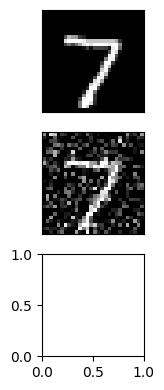

In [29]:
#모델 학습
import numpy as np

num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs) :
  print(f'EPOCH {epoch+1}/{num_epochs}')
  train_loss = train_epoch(encoder=encoder, decoder=decoder, device=device, dataloader=train_dataloader,
                           loss_fn=loss_fn, optimizer=optim, noise_factor=0.3)
  val_loss = test_epoch(encoder=encoder, decoder=decoder, device=device, dataloader=test_dataloader,
                        loss_fn=loss_fn, noise_factor=0.3)
  history_da['train_loss'].append(train_loss)
  history_da['val_loss'].append(val_loss)
  print(f'\n Epoch {epoch+1}/{num_epochs} \t train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
  plot_ae_outputs(encoder, decoder, noise_factor=0.3)

**13.2.2 변형 오토인코더**

In [30]:
pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.3 MB/s eta 0:00:00


In [31]:
#필요한 라이브러리 호출
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
#데이터셋 내려받고, 이미지->텐서 변환

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='/content/drive/MyDrive/pytorch_ex/chap13/data',
                               train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/content/drive/MyDrive/pytorch_ex/chap13/data',
                              train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [48]:
#인코더 네트워크 생성 : 데이터가 주어졌을 때 디코더가 원래 데이터로 잘 복원할 수 있는 이상적인 확률 분포 찾음(<->오토인코더: 그냥 정해져있는 분포 사용)
class Encoder(nn.Module) :
  def __init__(self, input_dim, hidden_dim, latent_dim) :
    super(Encoder, self).__init__()
    self.input1 = nn.Linear(input_dim, hidden_dim)
    self.input2 = nn.Linear(hidden_dim, latent_dim)
    self.mean = nn.Linear(hidden_dim, latent_dim) #평균
    self.var = nn.Linear(hidden_dim, latent_dim) #분산

    self.LeakyReLU = nn.LeakyReLU(0.2)
    self.training = True

  def forward(self, x) :
    h_ = self.LeakyReLU(self.input1(x))
    h_ = self.LeakyReLU(self.input2(h_))
    mean = self.mean(h_)
    log_var = self.var(h_)
    return mean, log_var #인코더에서 평균과 분산 반환

In [49]:
#디코더 네트워크 : 추출한 샘플을 입력으로 받아서 다시 원본으로 재구축(재생성)
class Decoder(nn.Module) :
  def __init__(self, latent_dim, hidden_dim, output_dim) :
    super(Decoder, self).__init__()
    self.hidden1 = nn.Linear(latent_dim, hidden_dim)
    self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.output = nn.Linear(hidden_dim, output_dim)
    self.LeakyReLU = nn.LeakyReLU(0.2)

  def forward(self, x) :
    h = self.LeakyReLU(self.hidden1(x))
    h = self.LeakyReLU(self.hidden2(x))
    x_hat = torch.sigmoid(self.output(h))
    return x_hat

In [50]:
#변형 오토인코더 네트워크
class Model(nn.Module) :
  def __init__(self, Encoder, Decoder) :
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def reparameterization(self, mean, var) : #평균과 표준편차가 주어졌을 떄 잠재벡터(z)를 만드는 함수
    epsilon = torch.randn_like(var).to(device)
    z = mean + var * epsilon
    return z

  def forward(self, x) :
    mean, log_var = self.Encoder(x)
    z = self.reparameterization(mean, torch.exp(0.5 * log_var))
    x_hat = self.Decoder(z)
    return x_hat, mean, log_var #디코더 결과, 평균, 표준편차 반환

In [51]:
#인코더와 디코더 객체 초기화
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [52]:
#오차 계산 위한 손실 함수 정의
def loss_function(x, x_hat, mean, log_var) :
  reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mean_pow(2) - log_var.exp())
  return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [53]:
#모델 학습 함수 정의
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()

def train(epoch, model, train_loader, optimizer) :
  train_loss = 0
  for vatch_idx, (x, _) in enumerate(train_loader) :
    x = x.view(batch_size, x_dim)
    x = x.to(device)

    optimizer.zero_grad()
    x_hat, mean, log_var = model(x)
    BCE, KLD = loss_function(x, x_hat, mean, log_var)
    loss = BCE + KLD
    writer.add_scalar( 'Train/Reconstruction Error', BCE.item(),
                       batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
    writer.add_scalar( 'Train/KL-Divergence', KLD.item(),
                       batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
    writer.add_scalar( 'Train/Total Loss', loss.item(),
                       batch_idx + epoch * (len(train_loader.dataset)/batch_size) )

    train_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0 :
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(epoch, batch_idx * len(x), (train_loader.dataset), 100. * batch_idx / len(train_loader)))

  print(f'=====> Epoch: {epoch} Average loss: {train_los / len(train_loader.dataset):.4f}')

In [54]:
#모델 평가 함수 정의

def test(epoch, model, test_loader) :
  model.eval()
  test_loss = 0
  with torch.no_grad() :
    for batch_idx, (x, _) in enumerate(test_loader) :
      x = x.view(batch_size, x_dim)
      x = x.to(device)
      x_hat, mean, log_var = model(x)
      BCE, KLD = loss_function(x, x_hat, mean, log_var)
      loss = BCE + KLD

    writer.add_scalar( 'Test/Reconstruction Error', BCE.item(),
                       batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
    writer.add_scalar( 'Test/KL-Divergence', KLD.item(),
                       batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
    writer.add_scalar( 'Test/Total Loss', loss.item(),
                       batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
    test_loss += loss.item()

    if batch_idx == 0 :
      n = min(x.size(0), 8)
      comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
      grid = torchvision.utils.make_grid(comparison.cpu())
      writer.add_image('Test image - Above: Real data, below: reconstruction data', grid, epoch)

In [55]:
#모델 학습
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)) :
  train(epoch, model, train_loader, optimizer)
  test(epoch, model, test_loader)
  print('\n')
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x200 and 400x200)

In [ ]:
#텐서보드에서 오차 확인
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

# 13.3 적대적 생성 신경망(Generative Adversarial Network, GAN)

- 판별자 D(Discriminator) : 주어진 입력 이미지가 진짜 이미지인지 가짜 이미지인지 구별.

  즉, 입력 이미지 x에 대하여 D(x)가 진짜 이미지일 확률 반환

- 생성자 G(Generator) : 실제 이미지를 학습해 노이즈 데이터를 사용하여 구분하기 어려운 모조 이미지를 생성

  즉, 진짜 이미지 z에 대하여 판별자가 G(z)를 입력으로 받아 D(G(z))를 1로 예측하게 하는 것이 목표

In [57]:
#라이브러리 호출
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
#변수 값 설정
batch_size = 512
epochs = 200
sample_size = 64 #생성자에 제공할 고정 크기 노이즈 벡터 크기
nz = 128 #잠재 벡터 크기(생성자의 입력 크기와 동일)
k = 1 #판별자에 적용할 스텝 수

In [59]:
#생성자 네트워크 생성
class Generator(nn.Module) :
  def __init__(self, nz) :
    super(Generator, self).__init__()
    self.nz = nz
    self.main = nn.Sequential(
        nn.Linear(self.nz, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
  def forward(self, x) :
    return self.main(x).view(-1, 1, 28, 28) #생성자 네트워크의 반환값 : '배치 크기x1x28x28'

In [86]:
#판별자 네트워크 생성 (이진 분류)

class Discriminator(nn.Module) :
  def __init__(self) :
    super(Discriminator, self).__init__()
    self.n_input = 784
    self.main = nn.Sequential(
        nn.Linear(self.n_input, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  def forward(self, x) :
    x = x.view(-1, 784)
    return self.main(x) #이미지가 진짜인지 가짜인지 분류하는 값 반환

In [87]:
#생성자와 판별자 네트워크 초기화
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [101]:
#옵티마이저와 손실 함수 정의 : 생성자와 판별자에서 사용할 옵티마이저를 >따로< 정의해야 함
optim_g = optim.Adam(generator.parameters(), lr=0.0002) #생성자의 옵티마이저
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002) #판별자의 옵티마이저

criterion = nn.BCELoss()

losses_g = [] #에포크마다 생성자 오차 저장 리스트
losses_d = [] #에포크마다 판별자 오차 저장 리스트
images = [] #생성자가 생성하는 이미지 저장 리스트

In [102]:
#생성한 이미지 저장 함수
def save_generator_image(image, path) :
  save_image(image, path)

In [103]:
#판별자 학습을 위한 함수
def train_discriminator(optimizer, data_real, data_fake) :
  b_size = data_real.size(0)
  real_label = torch.ones(b_size, 1).to(device) #전체 데이터에 대한 레이블 정보 텐서 (진짜이므로 레이블이 1)
  fake_label = torch.zeros(b_size, 1).to(device) #가짜 데이터에 대한 레이블 정보 텐서 (가짜이므로 레이블이 0)
  optimizer.zero_grad()
  output_real = discriminator(data_real)
  loss_real = criterion(output_real, real_label)
  output_fake = discriminator(data_fake)
  loss_fake = criterion(output_fake, fake_label)
  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real + loss_fake

In [104]:
#생성자 학습 위한 함수
def train_generator(optimizer, data_fake) :
  b_size = data_fake.size(0)
  real_label = torch.ones(b_size, 1).to(device)
  optimizer.zero_grad()
  output = discriminator(data_fake)
  loss = criterion(output, real_label)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
#모델 학습
generator.train()
discriminator.train()

for epoch in range(epochs) :
  loss_g = 0.0
  loss_d = 0.0
  for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)//train_loader.batch_size)) :
    image, _ = data
    image = image.to(device)
    b_size = len(image)
    for step in range(k) :
      data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
      data_real = image
      loss_d += train_discriminator(optim_d, data_real, data_fake)
    data_fake = generator(torch.randn(b_size, nz).to(device))
    loss_g += train_generator(optim_g, data_fake)
  generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
  generated_img = make_grid(generated_img)
  save_generator_image(generated_img, f'/content/drive/MyDrive/pytorch_ex/chap13/data/gen_img{epoch}.png')
  images.append(generated_img)
  epoch_loss_g = loss_g / idx
  epoch_loss_d = loss_d / idx
  losses_g.append(epoch_loss_g)
  losses_d.append(epoch_loss_d)

  print(f'Epoch {epoch} of {epochs}')
  print(f'Generator Loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 600/600 [01:15<00:00,  7.94it/s]

Epoch 0 of 200
Generator Loss: 2.60532069, Discriminator loss: 0.68645126



100%|██████████| 600/600 [01:12<00:00,  8.32it/s]

Epoch 1 of 200
Generator Loss: 2.55686641, Discriminator loss: 0.63636541



100%|██████████| 600/600 [01:14<00:00,  8.04it/s]

Epoch 2 of 200
Generator Loss: 2.38371110, Discriminator loss: 0.67563313



100%|██████████| 600/600 [01:15<00:00,  7.94it/s]

Epoch 3 of 200
Generator Loss: 2.39061356, Discriminator loss: 0.68801290



100%|██████████| 600/600 [01:13<00:00,  8.13it/s]

Epoch 4 of 200
Generator Loss: 2.02452350, Discriminator loss: 0.76222873



100%|██████████| 600/600 [01:11<00:00,  8.42it/s]

Epoch 5 of 200
Generator Loss: 2.05510187, Discriminator loss: 0.73811656



100%|██████████| 600/600 [01:14<00:00,  8.04it/s]

Epoch 6 of 200
Generator Loss: 2.22369003, Discriminator loss: 0.67843074



100%|██████████| 600/600 [01:13<00:00,  8.20it/s]

Epoch 7 of 200
Generator Loss: 2.14266133, Discriminator loss: 0.75003839



100%|██████████| 600/600 [01:10<00:00,  8.54it/s]

Epoch 8 of 200
Generator Loss: 2.17580152, Discriminator loss: 0.73809457



100%|██████████| 600/600 [01:11<00:00,  8.35it/s]

Epoch 9 of 200
Generator Loss: 2.44037986, Discriminator loss: 0.72306448



100%|██████████| 600/600 [01:08<00:00,  8.70it/s]

Epoch 10 of 200
Generator Loss: 2.15488577, Discriminator loss: 0.72204858



100%|██████████| 600/600 [01:09<00:00,  8.63it/s]

Epoch 11 of 200
Generator Loss: 2.24844050, Discriminator loss: 0.68287253



100%|██████████| 600/600 [01:09<00:00,  8.69it/s]

Epoch 12 of 200
Generator Loss: 2.17541599, Discriminator loss: 0.68671006



100%|██████████| 600/600 [01:06<00:00,  8.97it/s]

Epoch 13 of 200
Generator Loss: 2.26839709, Discriminator loss: 0.68150461



100%|██████████| 600/600 [01:07<00:00,  8.87it/s]

Epoch 14 of 200
Generator Loss: 2.21292901, Discriminator loss: 0.69587868



100%|██████████| 600/600 [01:06<00:00,  9.01it/s]

Epoch 15 of 200
Generator Loss: 2.54383588, Discriminator loss: 0.67280155



100%|██████████| 600/600 [01:07<00:00,  8.92it/s]

Epoch 16 of 200
Generator Loss: 2.27471352, Discriminator loss: 0.63874590



100%|██████████| 600/600 [01:09<00:00,  8.68it/s]

Epoch 17 of 200
Generator Loss: 2.32367110, Discriminator loss: 0.62485367



100%|██████████| 600/600 [01:07<00:00,  8.84it/s]

Epoch 18 of 200
Generator Loss: 2.34178114, Discriminator loss: 0.62111485



100%|██████████| 600/600 [01:14<00:00,  8.01it/s]

Epoch 19 of 200
Generator Loss: 2.45393610, Discriminator loss: 0.63057005



100%|██████████| 600/600 [01:11<00:00,  8.36it/s]

Epoch 20 of 200
Generator Loss: 2.48742867, Discriminator loss: 0.62563401



 82%|████████▏ | 490/600 [00:57<00:12,  8.52it/s]

In [ ]:
#생성자와 판별자의 오차 확인
plt.figure()
losses_g = [f1.item() for f1 in losses_g]
plt.plot(losses_g, label='Generator loss')
loss_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator loss')
plt.legend()

In [ ]:
#생성된 이미지 출력
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10) :
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.savefig('/content/drive/MyDrive/pytorch_ex/chap13/data/fake_images_img' + str(i) + '.png')